In [1]:
from Bio import SeqIO
import pandas as pd
import re

In [52]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

In [53]:
TITLE_SIZE = 30
LABEL_SIZE = 30
NOTE_SIZE = 20
rc('text', usetex=True)
rc = {'lines.linewidth': 2,
'axes.labelsize': LABEL_SIZE,
'axes.titlesize': TITLE_SIZE,
'legend.fontsize': 'x-large',
'font.family':'lato', 'font.serif':['lato'],
'axes.facecolor': 'DFDFE5'}
sns.set_context('paper', rc=rc)
sns.set_style('dark', rc=rc)

In [ ]:
gff3 = '../Ca_scaffolds/Ca_scaffolds.gff3'

In [ ]:
genoma_fasta = '../Ca_scaffolds/Ca_scaffolds.fasta'

In [ ]:
igenes = 'gene21015,gene6732,gene57633,gene29391,gene51461,gene28716,gene670,gene22342,gene42154,gene62527,gene6505,gene43153,gene41374,gene32,gene24835,gene21193,gene76719,gene43160,gene14033,gene25024,gene37874,gene61405,gene37751,gene1752,gene54807,gene7102,gene50370,gene43004,gene27402,gene11260,gene56882,gene14123,gene45233,gene12154,gene36792,gene74509,gene22710,gene48904,gene38562,gene71814,gene67924,gene71329,gene61988,gene20213,gene71768,gene33054,gene23340,gene27063,gene36349,gene36001,gene72390,gene37319,gene58278,gene47482,gene37851,gene15529,gene9026,gene59092,gene35221,gene53439,gene63086,gene73859,gene74066,gene66129,gene69370,gene10153,gene18780,gene59397,gene61490,gene11217,gene8217,gene29671,gene68399,gene9537,gene20668,gene7901,gene43645,gene18016,gene66077,gene49302,gene74040,gene75730,gene1651,gene76790,gene59434,gene39886,gene29208,gene36330,gene67353,gene66007,gene21657,gene7782,gene5797,gene43183,gene58119,gene60970,gene14520,gene34291,gene51028,gene55742,gene70956,gene40487,gene11437,gene76795,gene50770,gene56392,gene43617,gene21956,gene58866,gene34578,gene38154,gene44862,gene65679,gene39887,gene69654,gene31058,gene4598,gene32818,gene34245,gene7100,gene23573,gene8729,gene40058,gene734,gene55720,gene12648,gene11832,gene2776,gene63905,gene12324,gene53254,gene70928,gene77426,gene14512,gene6970,gene39039,gene16741,gene2476,gene9575,gene21492,gene56302,gene64875,gene69689,gene49283,gene77885,gene39635,gene59392,gene49121,gene60403,gene30238,gene12895,gene66169,gene22839,gene10428,gene23862,gene53362,gene42453,gene63201,gene13351,gene34225,gene20636,gene65931,gene76625,gene56006,gene29050,gene8619,gene76371,gene66723,gene14345,gene41208,gene58475,gene69372,gene64643,gene34262,gene68479,gene70542,gene2010,gene72622,gene65950,gene57941,gene67940,gene69365,gene48468,gene16068,gene38545,gene32750,gene60453,gene56884,gene27502'.split(',')

In [ ]:
entryes = [e.strip().split("\t") for e in open(gff3).readlines() if '\t' in e]

In [ ]:
class Entry:
    def __init__(self, parts, name='ID'):
        self.seq = parts[0]
        self.type = parts[2]
        self.start = int(parts[3])
        self.end = int(parts[4])
        self.size = 1 + self.end - self.start
        self.strand = parts[6]
        self.features = {z[0]: z[1].split(',') for z in [x.split('=') for x in parts[8].split(';')]}
        self.raw = parts
        self.childs = []
        self.gene = None
        self.id = self.features[name][0] if name in self.features else None
    
    def setGene(self, gene):
        self.gene = gene
        for child in self.childs:
            child.setGene(gene)
    
    def __repr__(self):
        return f"{self.type} {self.size}bp {self.strand} => {self.seq}"

In [ ]:
parsed_entryes = [Entry(e) for e in entryes]
del entryes

In [ ]:
parsed_entryes_dic = {e.id: e for e in parsed_entryes if e.id}

In [ ]:
print('Entrye types: %s' % ' '.join(set([e.type for e in parsed_entryes])))

In [ ]:
genes = [x for x in parsed_entryes if x.type.lower() == 'gene']
print('%d genes' % len(genes))

In [ ]:
mrnas = [x for x in parsed_entryes if x.type.lower() == 'mrna']
print('%d mRNAs' % len(mrnas))

In [ ]:
for entry in parsed_entryes:
    if 'Parent' in entry.features:
        parsed_entryes_dic[entry.features['Parent'][0]].childs.append(entry)

In [ ]:
for gene in genes:
    gene.setGene(gene)

In [ ]:
data = [(e.type, e.gene.id, e.size, e.strand, e.start, e.end, e.seq) for e in parsed_entryes if e.gene.id in igenes]

In [ ]:
del parsed_entryes
del parsed_entryes_dic

In [ ]:
df = pd.DataFrame(data, columns=['Tipo', 'Gene', 'Size', 'Strand','Start', 'End', 'Seq'])
del data

In [ ]:
fasta = SeqIO.to_dict(SeqIO.parse(genoma_fasta, 'fasta'))

In [ ]:
def statistics(group, utrs=['five_prime_UTR', 'three_prime_UTR']):
    
    def nrows(dx):
        return len(dx.index)
    seq= list(group.loc[group.Tipo == 'gene'].Seq)[0]
    
    gene_size = group.loc[group.Tipo == 'gene'].Size.max()
    mrna_count = nrows(group.loc[group.Tipo == 'mRNA'])
    t_mrna_size = group.loc[group.Tipo == 'mRNA'].Size.sum()
    d_mrna_size = gene_size - group.loc[group.Tipo == 'mRNA'].Size.mean()
    exon_count = nrows(group.loc[group.Tipo == 'exon'])
    m_exon_size = group.loc[group.Tipo == 'exon'].Size.mean()
    exon_size = group.loc[group.Tipo == 'exon'].Size.sum()
    utr_count = nrows(group.loc[group.Tipo.isin(utrs)])
    utr_size = group.loc[group.Tipo.isin(utrs)].Size.sum()
    m_intron_size = ((t_mrna_size - exon_size) / (exon_count - mrna_count)) if exon_count > 1 else 0
    cds_size = group.loc[group.Tipo == 'CDS'].Size.sum()
    
    st = group.loc[group.Tipo == 'CDS'].Start.min()
    ed = group.loc[group.Tipo == 'CDS'].End.max()
    
    sequence = str(fasta[seq].seq[st-1:ed]).upper()
    gc = len(sequence.replace('A','').replace('T',''))/len(sequence)
    complexity = len(set(re.split(r'(\w\w\w)', sequence)))-1
    
    return pd.Series([
        gene_size, mrna_count, d_mrna_size, exon_count, m_exon_size, utr_count, utr_size, m_intron_size, 
        cds_size, gc, complexity
    ], index=[
        'Gene size', 'mRNA count', 'mRNA size diff', 'Exon count', 'Exon size mean', 'UTR count', 'UTR total size', 
        'Intron mean size', 
        'Coding total size', 'GC%', 'Protein complexity'
    ]).fillna(0)


In [ ]:
res = df.groupby("Gene").apply(statistics)
res.head()

In [ ]:
res.to_csv("gene_summary.csv")

In [4]:
res = pd.read_csv("gene_summary.csv")

In [5]:
res= res.drop(columns=['Gene'])

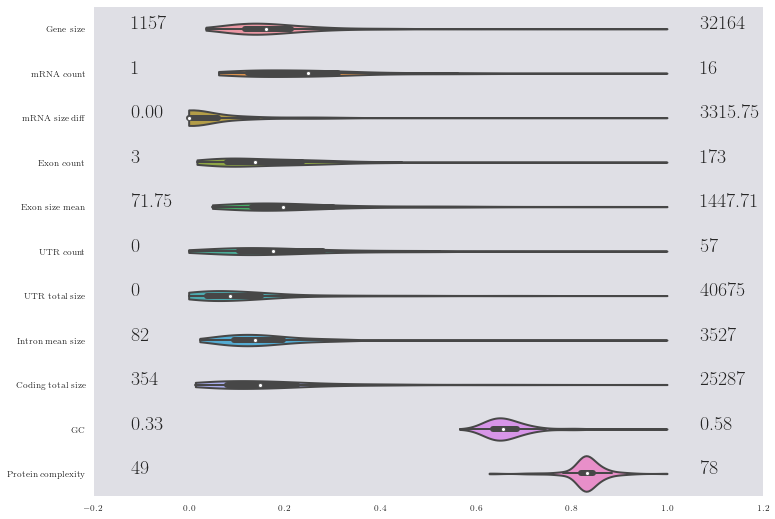

In [58]:
f, ax = plt.subplots(figsize=(12, 9))
sns.violinplot(data=res.apply(lambda c: c / c.max()), orient="h", cut=0)
la, lb = -.2, 1.2
plt.xlim([la, lb])
for c, a, b in [(i, res.iloc[:,i].min(),res.iloc[:,i].max())  for i in range(len(res.columns))]:
    ax.text(la+.08, c, ('%.2f' if c in [2, 4, 9] else '%d') % a, size=NOTE_SIZE)
    ax.text(lb-.13, c, ('%.2f' if c in [2, 4, 9] else '%d') % b, size=NOTE_SIZE)
ax.xaxis.label.set_size(40)
plt.savefig('gene_stats.png')